In [1]:
%matplotlib inline
from matplotlib import ticker 
littleh=0.7

In [2]:
from galsize_models.measurements import sdss_measurements
from galsize_models.measurements import load_umachine_sdss_with_meert15

full_sdss, behroozi_complete, good_profile_mask = load_umachine_sdss_with_meert15()
sdss = full_sdss[behroozi_complete & good_profile_mask]

from scipy.stats import binned_statistic
logsm_table = np.linspace(9, 12.25, 35)
logsm_mids = 0.5*(logsm_table[:-1] + logsm_table[1:])
sdss_r50_table, __, __ = binned_statistic(sdss['sm'], sdss['r50_magr_kpc_meert15'], 
                                            bins=logsm_table)

sdss['median_r50'] = 10**np.interp(sdss['sm'], logsm_mids, np.log10(sdss_r50_table))
sdss['small'] = sdss['r50_magr_kpc_meert15'] < sdss['median_r50']

from slidingpercentile import python_sliding_rank
x = sdss['sm']
y = sdss['r50_magr_kpc_meert15']
window_length = 1001

sliding_rank_orders = python_sliding_rank(x, y, window_length)
size_percentile = (1. + sliding_rank_orders)/float(window_length+1)
sdss['r50_percentile'] = size_percentile

In [3]:
from galsize_models.models import load_orphan_subhalos, moustakas_sham, orphan_selection
subhalos = load_orphan_subhalos()

subhalos['sm'] = moustakas_sham(subhalos['mpeak'], 0.25)

orphan_mask = orphan_selection(subhalos)

mock = subhalos[orphan_mask]

In [15]:
from galsize_models.models import component_size_vs_rhalo

normalization_all = 0.01
alpha_all = 1.
scatter_all = 0.2

mock['r50_nocorr'] = component_size_vs_rhalo(mock['rvir_zpeak'], 
                        normalization_all, alpha_all, 
                        scatter=scatter_all)

mock['r50_maxcorr'] = component_size_vs_rhalo(mock['rvir_zpeak'], 
                        normalization_all, alpha_all, 
                        scatter=scatter_all,
                        uran=1-mock['vmax_at_mpeak_percentile'])

mock['r50_midcorr'] = component_size_vs_rhalo(mock['rvir_zpeak'], 
                        normalization_all, alpha_all, 
                        scatter=scatter_all,
                        uran=1-mock['noisy_vmax_at_mpeak_percentile'])


In [16]:
mock_r50_table, __, __ = binned_statistic(mock['sm'], mock['r50_nocorr'], bins=logsm_table)
mock['median_r50'] = np.interp(mock['sm'], logsm_mids, np.log10(mock_r50_table))

mock['r50_mstar'] = 10**np.random.normal(loc=mock['median_r50'], scale=0.2)

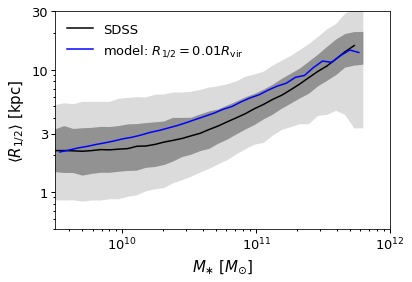

In [17]:
from scipy.special import erf, erfinv
def _percentile_from_z_score(z_score):
    return 0.5*(1 + erf(z_score/np.sqrt(2)))
low_percentile_1sigma, high_percentile_1sigma = _percentile_from_z_score(-1), _percentile_from_z_score(1)
low_percentile_3sigma, high_percentile_3sigma = _percentile_from_z_score(-3), _percentile_from_z_score(3)

logsm_table = np.linspace(9.5, 11.8, 35)
dlogsm = 0.05

r50_table_median = np.zeros_like(logsm_table)
r50_table_1sigma_low = np.zeros_like(logsm_table)
r50_table_1sigma_high = np.zeros_like(logsm_table)
r50_table_3sigma_low = np.zeros_like(logsm_table)
r50_table_3sigma_high = np.zeros_like(logsm_table)

for i, logsm in enumerate(logsm_table):
    mask = np.abs(sdss['sm'] - logsm) < dlogsm
    assert np.count_nonzero(mask) > 100, logsm
    sample_r50 = sdss['r50_magr_kpc_meert15'][mask]
    sample_r50_percentile = sdss['r50_percentile'][mask]
    
    mask_median = np.abs(sample_r50_percentile - 0.5) < 0.01
    r50_table_median[i] = np.median(sample_r50[mask_median])
    
    mask_p50 = (sample_r50_percentile > 0.25) & (sample_r50_percentile < 0.75)
    r50_table_1sigma_low[i] = np.min(sample_r50[mask_p50])
    r50_table_1sigma_high[i] = np.max(sample_r50[mask_p50])

    mask_p90 = (sample_r50_percentile > 0.05) & (sample_r50_percentile < 0.95)
    r50_table_3sigma_low[i] = np.min(sample_r50[mask_p90])
    r50_table_3sigma_high[i] = np.max(sample_r50[mask_p90])

from scipy.stats import binned_statistic
mock_r50_median, __, __ = binned_statistic(
            mock['sm'], mock['r50_nocorr'], bins=logsm_table)
logsm_mids = 0.5*(logsm_table[:-1] + logsm_table[1:])

fig, ax = plt.subplots(1, 1)
__=ax.loglog()

xmin, xmax = 10**9.5, 10**12
ymin, ymax = 0.5, 30
_xlabel = r'$M_{\ast}$ $[M_{\odot}]$'
_ylabel = r'$\langle R_{1/2} \rangle$ $[{\rm kpc}]$'
xlim = ax.set_xlim(xmin, xmax)
ylim = ax.set_ylim(ymin, ymax)
__=ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
__=ax.set_yticks((1, 3, 10, 30))

ylabel=ax.set_ylabel(_ylabel)
xlabel=ax.set_xlabel(_xlabel)

__=ax.plot(10**logsm_table, r50_table_median, color='k', label='SDSS')
__=ax.plot(10**logsm_mids, mock_r50_median, color='blue', 
           label=r'model: $R_{1/2}=0.01R_{\rm vir}$')

y1, y2 = r50_table_3sigma_low, r50_table_3sigma_high
__=ax.fill_between(10**logsm_table, y1, y2, facecolor='lightgray', alpha=0.8)

y1, y2 = r50_table_1sigma_low, r50_table_1sigma_high
__=ax.fill_between(10**logsm_table, y1, y2, facecolor='gray', alpha=0.8)


leg = ax.legend()

figname = 'rvir_only_rhalf_vs_mstar_sham_model.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


In [18]:
from galsize_models.measurements import single_component_clustering

In [19]:
mock['r50'] = mock['r50_nocorr']
median_rhalf_mock, __, __ = binned_statistic(mock['sm'], mock['r50'], bins=logsm_table)

mock['r50_median'] = np.interp(mock['sm'], logsm_mids, median_rhalf_mock)

_x = single_component_clustering(mock)
rp_mids = _x[0]
wp_small_mock_sm9p75_nocorr, wp_all_mock_sm9p75_nocorr, wp_large_mock_sm9p75_nocorr = _x[1]
wp_small_mock_sm10p25_nocorr, wp_all_mock_sm10p25_nocorr, wp_large_mock_sm10p25_nocorr = _x[2]
wp_small_mock_sm10p75_nocorr, wp_all_mock_sm10p75_nocorr, wp_large_mock_sm10p75_nocorr = _x[3]
wp_small_mock_sm11p0_nocorr, wp_all_mock_sm11p0_nocorr, wp_large_mock_sm11p0_nocorr = _x[4]
wp_small_mock_sm11p25_nocorr, wp_all_mock_sm11p25_nocorr, wp_large_mock_sm11p25_nocorr = _x[5]


In [20]:
mock['r50'] = mock['r50_midcorr']
median_rhalf_mock, __, __ = binned_statistic(mock['sm'], mock['r50'], bins=logsm_table)

mock['r50_median'] = np.interp(mock['sm'], logsm_mids, median_rhalf_mock)

_x = single_component_clustering(mock)
rp_mids = _x[0]
wp_small_mock_sm9p75_midcorr, wp_all_mock_sm9p75_midcorr, wp_large_mock_sm9p75_midcorr = _x[1]
wp_small_mock_sm10p25_midcorr, wp_all_mock_sm10p25_midcorr, wp_large_mock_sm10p25_midcorr = _x[2]
wp_small_mock_sm10p75_midcorr, wp_all_mock_sm10p75_midcorr, wp_large_mock_sm10p75_midcorr = _x[3]
wp_small_mock_sm11p0_midcorr, wp_all_mock_sm11p0_midcorr, wp_large_mock_sm11p0_midcorr = _x[4]
wp_small_mock_sm11p25_midcorr, wp_all_mock_sm11p25_midcorr, wp_large_mock_sm11p25_midcorr = _x[5]


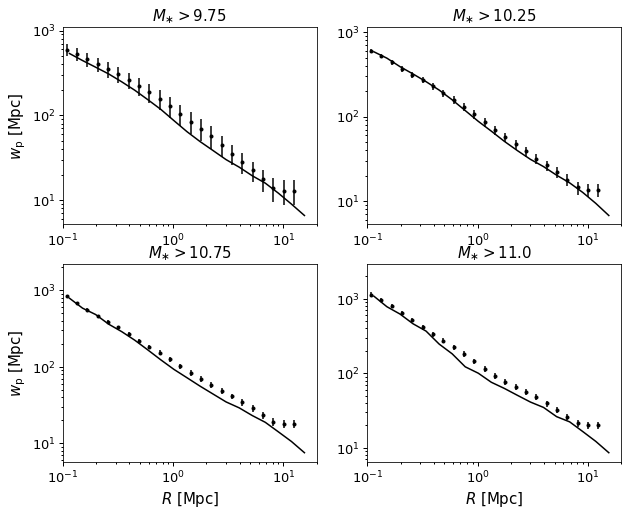

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    __=ax.loglog()
    xlim = ax.set_xlim(0.1, 20)

xlabel3 = ax3.set_xlabel(r'$R$ $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$R$ $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
ylabel3 = ax3.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')

x = sdss_measurements.rp*littleh
__=ax1.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm9p75*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm9p75*littleh, 
               fmt='.', color='k', label=r'SDSS')
__=ax2.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p25*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p25*littleh, 
               fmt='.', color='k', label=r'SDSS')
__=ax3.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p75*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p75*littleh, 
               fmt='.', color='k', label=r'SDSS')
__=ax4.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm11p0*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm11p0*littleh, 
               fmt='.', color='k', label=r'SDSS')

__=ax1.plot(rp_mids, wp_all_mock_sm9p75_nocorr, color='k', label=r'SHAM + orphans')
__=ax2.plot(rp_mids, wp_all_mock_sm10p25_nocorr, color='k', label=r'SHAM + orphans')
__=ax3.plot(rp_mids, wp_all_mock_sm10p75_nocorr, color='k', label=r'SHAM + orphans')
__=ax4.plot(rp_mids, wp_all_mock_sm11p0_nocorr, color='k', label=r'SHAM + orphans')


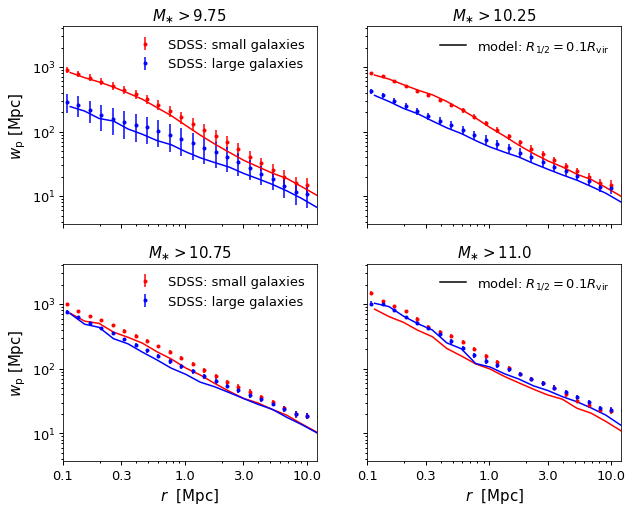

In [22]:
from galsize_models.measurements import sdss_measurements
littleh = 0.7
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    __=ax.loglog()
    xlim = ax.set_xlim(0.1, 12)

xlabel3 = ax3.set_xlabel(r'$r$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
ylabel3 = ax3.set_ylabel(r'$w_{\rm p}$ $[{\rm Mpc}]$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')

ifirst=0
x = sdss_measurements.rp*littleh
__=ax1.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm9p75_small*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm9p75*littleh, 
               fmt='.', color='red', label=r'SDSS: small galaxies')
__=ax2.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p25_small*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p25*littleh, 
               fmt='.', color='red')
__=ax3.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p75_small*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p75*littleh, 
               fmt='.', color='red', label=r'SDSS: small galaxies')
__=ax4.errorbar(x[ifirst:], 
               sdss_measurements.wp_sdss_mpajhu_sm11p0_small[ifirst:]*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm11p0[ifirst:]*littleh, 
               fmt='.', color='red')

__=ax1.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm9p75_large*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm9p75*littleh, 
               fmt='.', color='blue', label=r'SDSS: large galaxies')
__=ax2.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p25_large*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p25*littleh, 
               fmt='.', color='blue')
__=ax3.errorbar(x, 
               sdss_measurements.wp_sdss_mpajhu_sm10p75_large*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm10p75*littleh, 
               fmt='.', color='blue', label=r'SDSS: large galaxies')
__=ax4.errorbar(x[ifirst:], 
               sdss_measurements.wp_sdss_mpajhu_sm11p0_large[ifirst:]*littleh, 
               sdss_measurements.wperr_sdss_mpajhu_sm11p0[ifirst:]*littleh, 
               fmt='.', color='blue')

ifirst=0
__=ax1.plot(rp_mids, wp_small_mock_sm9p75_nocorr, color='red')
__=ax2.plot(rp_mids, wp_small_mock_sm10p25_nocorr, color='red', 
            label=r'model: $R_{1/2}=0.1R_{\rm vir}$')
__=ax3.plot(rp_mids, wp_small_mock_sm10p75_nocorr, color='red')
__=ax4.plot(rp_mids[ifirst:], wp_small_mock_sm11p0_nocorr[ifirst:], color='red', 
            label=r'model: $R_{1/2}=0.1R_{\rm vir}$')

__=ax1.plot(rp_mids, wp_large_mock_sm9p75_nocorr, color='blue')
__=ax2.plot(rp_mids, wp_large_mock_sm10p25_nocorr, color='blue')
__=ax3.plot(rp_mids, wp_large_mock_sm10p75_nocorr, color='blue')
__=ax4.plot(rp_mids[ifirst:], wp_large_mock_sm11p0_nocorr[ifirst:], color='blue')

__=ax1.get_xaxis().set_major_formatter(ticker.NullFormatter())
__=ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_major_formatter(ticker.NullFormatter())
__=ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())

__=ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax3.set_xticks((0.1, 0.3, 1, 3, 10))
__=ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())
__=ax4.set_xticks((0.1, 0.3, 1, 3, 10))

figname = 'rvir_only_wp_large_small_absolute.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')

leg1 = ax1.legend()
leg2 = ax2.legend()
leg3 = ax3.legend()
leg4 = ax4.legend()
leg2.legendHandles[0].set_color('k')
leg4.legendHandles[0].set_color('k')

figname = 'rvir_only_wp_large_small_absolute.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


In [23]:
fracdiff_sm9p75_midcorr = (wp_large_mock_sm9p75_midcorr-wp_small_mock_sm9p75_midcorr)/wp_all_mock_sm9p75_midcorr
fracdiff_sm10p25_midcorr = (wp_large_mock_sm10p25_midcorr-wp_small_mock_sm10p25_midcorr)/wp_all_mock_sm10p25_midcorr
fracdiff_sm10p75_midcorr = (wp_large_mock_sm10p75_midcorr-wp_small_mock_sm10p75_midcorr)/wp_all_mock_sm10p75_midcorr
fracdiff_sm11p0_midcorr = (wp_large_mock_sm11p0_midcorr-wp_small_mock_sm11p0_midcorr)/wp_all_mock_sm11p0_midcorr
fracdiff_sm11p25_midcorr = (wp_large_mock_sm11p25_midcorr-wp_small_mock_sm11p25_midcorr)/wp_all_mock_sm11p25_midcorr

In [24]:
fracdiff_sm9p75_nocorr = (wp_large_mock_sm9p75_nocorr-wp_small_mock_sm9p75_nocorr)/wp_all_mock_sm9p75_nocorr
fracdiff_sm10p25_nocorr = (wp_large_mock_sm10p25_nocorr-wp_small_mock_sm10p25_nocorr)/wp_all_mock_sm10p25_nocorr
fracdiff_sm10p75_nocorr = (wp_large_mock_sm10p75_nocorr-wp_small_mock_sm10p75_nocorr)/wp_all_mock_sm10p75_nocorr
fracdiff_sm11p0_nocorr = (wp_large_mock_sm11p0_nocorr-wp_small_mock_sm11p0_nocorr)/wp_all_mock_sm11p0_nocorr
fracdiff_sm11p25_nocorr = (wp_large_mock_sm11p25_nocorr-wp_small_mock_sm11p25_nocorr)/wp_all_mock_sm11p25_nocorr

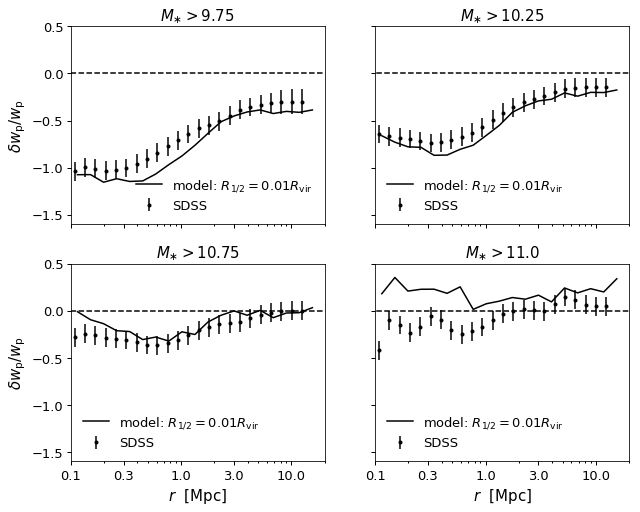

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
(ax1, ax2), (ax3, ax4) = axes

for ax in (ax1, ax2, ax3, ax4):
    xscale = ax.set_xscale('log')
    xlim = ax.set_xlim(0.1, 20)
    ylim = ax.set_ylim(-1.6, 0.5)
    __=ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')

xlabel3 = ax3.set_xlabel(r'$r$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$r$  $[{\rm Mpc}]$')
ylabel1 = ax1.set_ylabel(r'$\delta w_{\rm p} / w_{\rm p}$')
ylabel3 = ax3.set_ylabel(r'$\delta w_{\rm p} / w_{\rm p}$')
    
title1 = ax1.set_title(r'$M_{\ast}>9.75$')
title2 = ax2.set_title(r'$M_{\ast}>10.25$')
title3 = ax3.set_title(r'$M_{\ast}>10.75$')
title4 = ax4.set_title(r'$M_{\ast}>11.0$')

ifirst=0
x = sdss_measurements.rp*littleh
__=ax1.errorbar(x, sdss_measurements.fracdiff_sm9p75_mpajhu, 
                sdss_measurements.fracdiff_sm9p75_mpajhu_err, 
               fmt='.', color='k', label=r'SDSS')
__=ax2.errorbar(x, sdss_measurements.fracdiff_sm10p25_mpajhu, 
                sdss_measurements.fracdiff_sm10p25_mpajhu_err, 
               fmt='.', color='k', label=r'SDSS')
__=ax3.errorbar(x, sdss_measurements.fracdiff_sm10p75_mpajhu, 
                sdss_measurements.fracdiff_sm10p75_mpajhu_err, 
               fmt='.', color='k', label=r'SDSS')
__=ax4.errorbar(x[ifirst:], sdss_measurements.fracdiff_sm11p0_mpajhu[ifirst:], 
                sdss_measurements.fracdiff_sm11p0_mpajhu_err[ifirst:], 
               fmt='.', color='k', label=r'SDSS')

ifirst=0
__=ax1.plot(rp_mids, fracdiff_sm9p75_nocorr, color='k', 
           label=r'model: $R_{1/2}=0.01R_{\rm vir}$')
__=ax2.plot(rp_mids, fracdiff_sm10p25_nocorr, color='k', 
           label=r'model: $R_{1/2}=0.01R_{\rm vir}$')
__=ax3.plot(rp_mids, fracdiff_sm10p75_nocorr, color='k', 
           label=r'model: $R_{1/2}=0.01R_{\rm vir}$')
__=ax4.plot(rp_mids[ifirst:], fracdiff_sm11p0_nocorr[ifirst:], color='k', 
            label=r'model: $R_{1/2}=0.01R_{\rm vir}$')

ax3.set_xticks((0.1, 0.3, 1, 3, 10))
ax4.set_xticks((0.1, 0.3, 1, 3, 10))
ax1.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax1.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax2.get_xaxis().set_major_formatter(ticker.NullFormatter())
ax3.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax3.get_xaxis().set_minor_formatter(ticker.NullFormatter())
ax4.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
ax4.get_xaxis().set_minor_formatter(ticker.NullFormatter())

labels = [item.get_text() for item in ax2.get_yticklabels()]
empty_string_labels = ['']*len(labels)
ax2.set_yticklabels(empty_string_labels)
ax4.set_yticklabels(empty_string_labels)

legend = ax1.legend()
legend = ax2.legend()
legend = ax3.legend()
legend = ax4.legend()

figname = 'rvir_only_wp_ratios.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')
